<a href="https://colab.research.google.com/github/ASHIKAMOHAN/GalaxyProject/blob/main/GalaxyDistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Function to load datasets
def load_data():
    happy_files = [
        '/content/drive/MyDrive/GalaxyProject/Happy/happy_A.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/happy_B.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/happy_C.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/happy_D.txt'
    ]
    teddy_files = [
        '/content/drive/MyDrive/GalaxyProject/Teddy/teddy_A.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/teddy_B.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/teddy_C.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/teddy_D.txt'
    ]

    happy_dfs = [pd.read_csv(file, delimiter='\t') for file in happy_files]
    teddy_dfs = [pd.read_csv(file, delimiter='\t', skiprows=6) for file in teddy_files]

    return happy_dfs, teddy_dfs



In [ ]:
# Load datasets
happy_dfs, teddy_dfs = load_data()

# Define the correct column names
column_names = ['id', 'mag_r', 'u-g', 'g-r', 'r-i', 'i-z', 'z_spec', 'feat1', 'feat2', 'feat3', 'feat4', 'feat5']

In [ ]:
# Clean and rename columns
def clean_and_rename_columns(dfs, column_names):
    cleaned_dfs = []
    for df in dfs:
        if df.shape[1] == 1:
            df = df.iloc[:, 0].str.split(expand=True)
        df.columns = column_names
        cleaned_dfs.append(df)
    return cleaned_dfs

# Apply the function to all datasets
happy_dfs = clean_and_rename_columns(happy_dfs, column_names)
teddy_dfs = clean_and_rename_columns(teddy_dfs, column_names)



In [ ]:
# Preprocess data
def preprocess_data(df):
    X = df.drop('z_spec', axis=1).astype(float)
    y = df['z_spec'].astype(float)
    return X, y

# Preprocess the datasets
# Happy datasets
X_train_happy, y_train_happy = preprocess_data(happy_dfs[0])  # Happy A: Training/Calibration set
X_val_happy, y_val_happy = preprocess_data(happy_dfs[1])      # Happy B: Validation set
X_test_happy, y_test_happy = preprocess_data(happy_dfs[2])    # Happy C: Validation set
# Happy D is not used

# Teddy datasets
X_train_teddy, y_train_teddy = preprocess_data(teddy_dfs[0])  # Teddy A: Training/Calibration set
X_val_teddy, y_val_teddy = preprocess_data(teddy_dfs[1])      # Teddy B: Validation set
X_test_teddy, y_test_teddy = preprocess_data(teddy_dfs[2])    # Teddy C: Validation set
# Teddy D is not used

# Combine Happy and Teddy datasets for a comprehensive training set
X_train = pd.concat([X_train_happy, X_train_teddy])
y_train = pd.concat([y_train_happy, y_train_teddy])

X_val = pd.concat([X_val_happy, X_val_teddy])
y_val = pd.concat([y_val_happy, y_val_teddy])

X_test = pd.concat([X_test_happy, X_test_teddy])
y_test = pd.concat([y_test_happy, y_test_teddy])



In [ ]:
# Check for and handle NaN values
def handle_nan(df):
    if df.isnull().values.any():
        df = df.fillna(df.mean())
    return df

# Apply NaN handling to datasets
X_train = handle_nan(X_train)
X_val = handle_nan(X_val)
X_test = handle_nan(X_test)
y_train = handle_nan(y_train)
y_val = handle_nan(y_val)
y_test = handle_nan(y_test)

# Verify no NaN values are present
def verify_no_nan(df, name):
    if df.isnull().values.any():
        print(f"NaN values found in {name}")
    else:
        print(f"No NaN values in {name}")

# Verify all datasets
verify_no_nan(X_train, 'X_train')
verify_no_nan(X_val, 'X_val')
verify_no_nan(X_test, 'X_test')
verify_no_nan(y_train, 'y_train')
verify_no_nan(y_val, 'y_val')
verify_no_nan(y_test, 'y_test')

No NaN values in X_train
No NaN values in X_val
No NaN values in X_test
No NaN values in y_train
No NaN values in y_val
No NaN values in y_test


In [ ]:
# Load weights
def load_weights():
    weight_files = [
        '/content/drive/MyDrive/GalaxyProject/Happy/weights_for_B.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/weights_for_C.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/weights_for_D.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/weights_for_B.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/weights_for_C.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/weights_for_D.txt'
    ]
    weights = [pd.read_csv(file, delimiter='\t', header=None).values.flatten() for file in weight_files]
    return weights

weights = load_weights()

# Adjust weights lengths to match validation and test sets
def adjust_weights(weights, X_val_happy, X_val_teddy, X_test_happy, X_test_teddy):
    len_val_happy = len(X_val_happy)
    len_val_teddy = len(X_val_teddy)
    len_test_happy = len(X_test_happy)
    len_test_teddy = len(X_test_teddy)

    weights_val = np.concatenate([weights[0][:len_val_happy], weights[3][:len_val_teddy]])
    weights_test = np.concatenate([weights[1][:len_test_happy], weights[4][:len_test_teddy]])

    # If weights_val is shorter than X_val, we fill the rest with 1s to match the length
    if len(weights_val) < len(X_val):
        weights_val = np.concatenate([weights_val, np.ones(len(X_val) - len(weights_val))])

    # If weights_test is shorter than X_test, we fill the rest with 1s to match the length
    if len(weights_test) < len(X_test):
        weights_test = np.concatenate([weights_test, np.ones(len(X_test) - len(weights_test))])

    return weights_val, weights_test

weights_val, weights_test = adjust_weights(weights, X_val_happy, X_val_teddy, X_test_happy, X_test_teddy)

In [ ]:
# Check for consistency in data lengths
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of X_val:", len(X_val))
print("Length of y_val:", len(y_val))
print("Length of weights_val:", len(weights_val))
print("Length of X_test:", len(X_test))
print("Length of y_test:", len(y_test))
print("Length of weights_test:", len(weights_test))

Length of X_train: 149259
Length of y_train: 149259
Length of X_val: 149457
Length of y_val: 149457
Length of weights_val: 149457
Length of X_test: 158295
Length of y_test: 158295
Length of weights_test: 158295


In [28]:
# Model training functions

# Random Forest
def train_random_forest(X_train, y_train, X_val, y_val, weights_train, weights_val):
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train, sample_weight=weights_train)
    y_pred_rf = rf.predict(X_val)
    rmse_rf = mean_squared_error(y_val, y_pred_rf, squared=False, sample_weight=weights_val)
    return y_pred_rf, rmse_rf

# Gradient Boosting
def train_gradient_boost(X_train, y_train, X_val, y_val, weights_train, weights_val):
    gb = GradientBoostingRegressor()
    gb.fit(X_train, y_train, sample_weight=weights_train)
    y_pred_gb = gb.predict(X_val)
    rmse_gb = mean_squared_error(y_val, y_pred_gb, squared=False, sample_weight=weights_val)
    return y_pred_gb, rmse_gb



In [29]:
# Gaussian Process from scratch
class GaussianProcessScratch:
    def __init__(self, X_train, y_train, l=1.0, sigma_f=1.0):
        self.X_train = X_train
        self.y_train = y_train
        self.l = l
        self.sigma_f = sigma_f
        self.K = self.kernel(self.X_train, self.X_train)

    def kernel(self, X1, X2):
        sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
        return self.sigma_f**2 * np.exp(-0.5 / self.l**2 * sqdist)

    def predict(self, X_s):
        K_s = self.kernel(self.X_train, X_s)
        K_ss = self.kernel(X_s, X_s)
        K_inv = np.linalg.inv(self.K)

        mu_s = K_s.T.dot(K_inv).dot(self.y_train)
        cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

        return mu_s

# Neural Network from scratch
class NeuralNetworkScratch:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01, epochs=1000):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.W1 = np.random.randn(input_size, hidden_size)
        self.W2 = np.random.randn(hidden_size, output_size)
    def sigmoid(self, x):
      return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
      return x * (1 - x)

    def fit(self, X, y):
      for epoch in range(self.epochs):
        # Forward pass
        z1 = np.dot(X, self.W1)
        a1 = self.sigmoid(z1)
        z2 = np.dot(a1, self.W2)
        a2 = z2

        # Backward pass
        error = a2 - y
        d_z2 = error
        d_W2 = np.dot(a1.T, d_z2)

        d_a1 = np.dot(d_z2, self.W2.T)
        d_z1 = d_a1 * self.sigmoid_derivative(a1)
        d_W1 = np.dot(X.T, d_z1)

        # Update weights
        self.W1 -= self.learning_rate * d_W1
        self.W2 -= self.learning_rate * d_W2

    def predict(self, X):
      z1 = np.dot(X, self.W1)
      a1 = self.sigmoid(z1)
      z2 = np.dot(a1, self.W2)
      return z2

In [30]:
# Ensure weights_train is consistent
weights_train = np.ones(len(X_train))

In [31]:
y_pred_rf, rmse_rf = train_random_forest(X_train, y_train, X_val, y_val, weights_train, weights_val)
print(f'Random Forest RMSE: {rmse_rf}’)

KeyboardInterrupt: 

In [ ]:
y_pred_gb, rmse_gb = train_gradient_boost(X_train, y_train, X_val, y_val, weights_train, weights_val)
print(f'Gradient Boost RMSE: {rmse_gb}’)

Gradient Boost RMSE: 0.046741091788792925


In [ ]:
gp_scratch = GaussianProcessScratch(X_train.values, y_train.values)
y_pred_gp_scratch = gp_scratch.predict(X_val.values)
rmse_gp_scratch = mean_squared_error(y_val, y_pred_gp_scratch, squared=False)
print(f'Gaussian Process Scratch RMSE: {rmse_gp_scratch}')

In [ ]:
nn_scratch = NeuralNetworkScratch(input_size=X_train.shape[1], hidden_size=64, output_size=1, learning_rate=0.01, epochs=1000)
nn_scratch.fit(X_train.values, y_train.values)
y_pred_nn_scratch = nn_scratch.predict(X_val.values)
rmse_nn_scratch = mean_squared_error(y_val, y_pred_nn_scratch.flatten(), squared=False)
print(f'Neural Network Scratch RMSE: {rmse_nn_scratch}’)

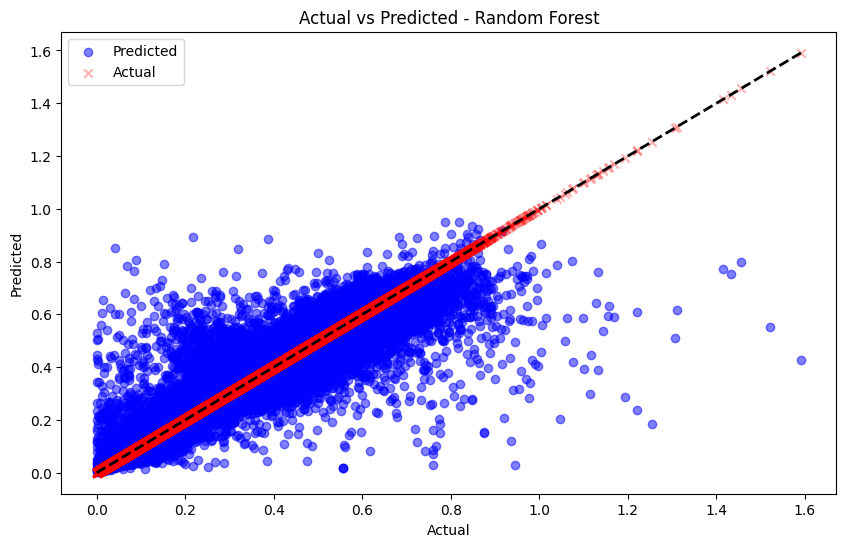

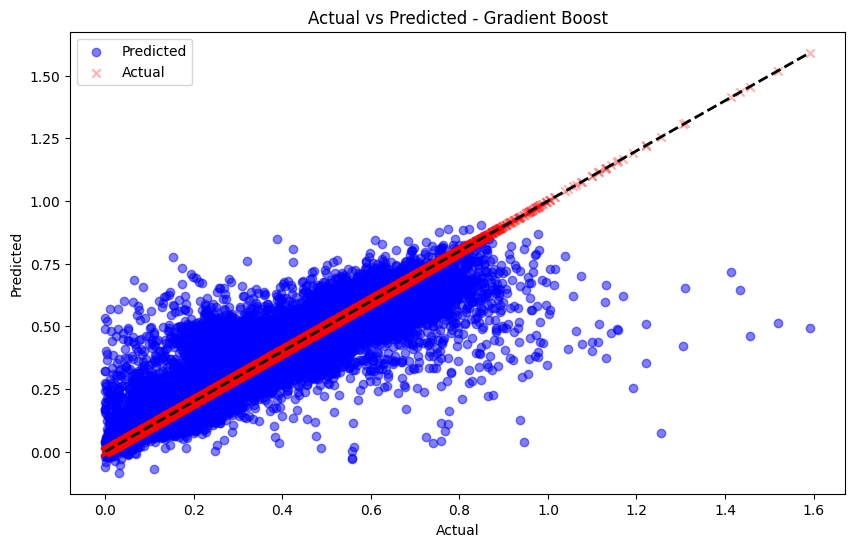

In [ ]:
# Visualization function with distinct markers and colors
def visualize_results(y_test, predictions, labels):
    for y_pred, label in zip(predictions, labels):
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, label='Predicted', color='blue', alpha=0.5, marker='o')
        plt.scatter(y_test, y_test, label='Actual', color='red', alpha=0.3, marker='x')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.title(f'Actual vs Predicted - {label}')
        plt.show()

# Visualize results
predictions = [y_pred_rf, y_pred_gb, y_pred_gp_scratch, y_pred_nn_scratch]
labels = ['Random Forest', 'Gradient Boost', 'Gaussian Process Scratch', 'Neural Network Scratch']
visualize_results(y_val, predictions, labels)

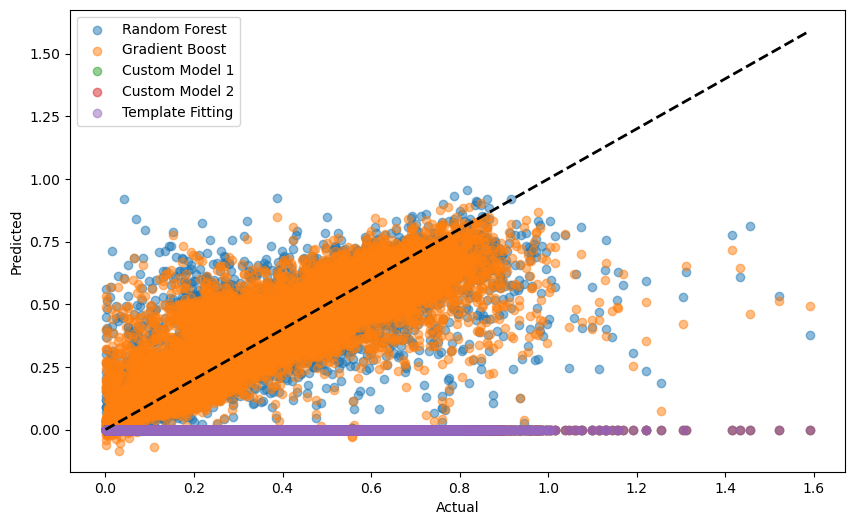

In [ ]:
predictions = [y_pred_rf, y_pred_gb, y_pred_c1, y_pred_c2, y_pred_tf]
labels = ['Random Forest', 'Gradient Boost', 'Custom Model 1', 'Custom Model 2', 'Template Fitting']
visualize_results(y_val, predictions, labels)